# start

In [1]:
PRFX = 'DevAdvVal0808_3'
p_o = f'../output/{PRFX}'

In [2]:
BS = 16
SZ = 456

FP16 = True

DBG = False

use_open_yz = True

In [3]:
# Downloading: "http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth" to /tmp/.cache/torch/checkpoints/efficientnet-b3-c8376fa2.pth
import os
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')

!cp ../input/efficientnetpytorch/*.pth /tmp/.cache/torch/checkpoints/

In [4]:
!pip install ../input/efficientnetpytorch/efficientnet_pytorch-0.3.0-py3-none-any.whl

In [5]:
from fastai.vision import *
import cv2

In [6]:
def crop_margin(image, keep_less=0.83):
    
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        #print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*keep_less
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        #print('none!')
        flag = 0
        return image,flag

    
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img):        
    
    h0, w0 = 480, 640 #most common in test
    ratio = h0/w0 #most common in test
    height, width, _= img.shape
    new_width, new_height = width, math.ceil(width*ratio)

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def open_yz(fn, convert_mode, after_open)->Image:
    image = load_ben_color(fn)
    return Image(pil2tensor(image, np.float32).div_(255))
    
def load_ben_color(fn)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = crop_image_from_gray(image)
    image, _ = crop_margin(image)
    image = center_crop(image)
    image = cv2.resize(image, (640, 480))#most common in test
#     image = cv2.resize(image, (SZ, SZ))
    image = cv2.addWeighted(image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) , -4 ,128)
    return image

if use_open_yz:
    vision.data.open_image = open_yz

# data

In [7]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
train_diab = pd.read_csv('../input/diabetic-retinopathy-resized//trainLabels.csv')

train.shape, test.shape, train_diab.shape

((3662, 2), (1928, 1), (35126, 2))

In [8]:
p = '../input/aptos2019-blindness-detection'
pp = Path(p)
img2grd_blnd_train = [(f'{pp}/train_images/{o[0]}.png',1)  for o in train.values]
img2grd_blnd_test  = [(f'{pp}/test_images/{o[0]}.png', 1)  for o in test.values]
p = '../input/diabetic-retinopathy-resized/resized_train/'
pp = Path(p)
img2grd_diab  = [(f'{pp}/{o[0]}.jpeg', 0)  for o in train_diab.values]

img2grd = img2grd_blnd_train+img2grd_blnd_test+img2grd_diab
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target']

if DBG:
    df = df.sample(2000)

40716

[(0, 35126), (1, 5590)]

In [9]:
df.shape

(40716, 2)

In [10]:
df.target.value_counts()

0    35126
1     5590
Name: target, dtype: int64

In [11]:
df.sample(5)

fnm  target
1520   ../input/aptos2019-blindness-detection/train_i...       1
36142  ../input/diabetic-retinopathy-resized/resized_...       0
22838  ../input/diabetic-retinopathy-resized/resized_...       0
22085  ../input/diabetic-retinopathy-resized/resized_...       0
35587  ../input/diabetic-retinopathy-resized/resized_...       0

In [12]:
%%time
tfms = []

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_none()
            .label_from_df(cols='target')
          )

    data= (src.transform(tfms, size=sz) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data


bs = BS 
sz = SZ
data = get_data(sz, bs)

CPU times: user 3.7 s, sys: 196 ms, total: 3.89 s
Wall time: 1.9 s


CPU times: user 4.47 s, sys: 1.75 s, total: 6.22 s
Wall time: 10.1 s


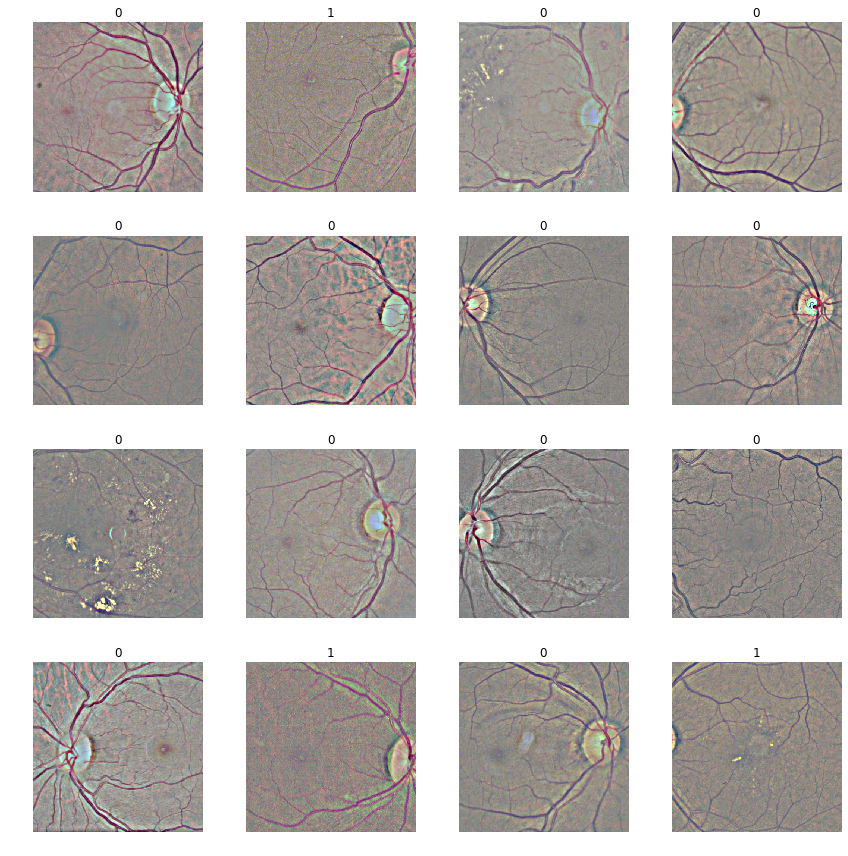

In [13]:
%%time
data.show_batch(rows=4, figsize=(12,12))

# model

In [14]:
from efficientnet_pytorch import EfficientNet

MODEL_NAME = 'efficientnet-b5'
model = EfficientNet.from_pretrained(MODEL_NAME, num_classes=2) 
learn = Learner(data, model, path=p_o, 
#                 wd=WD,  
#                 metrics=[accuracy, qwk],
               )

if FP16: learn = learn.to_fp16()

Loaded pretrained weights for efficientnet-b5


In [15]:
!nvidia-smi

Thu Aug  8 19:30:23 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   60C    P0    45W / 300W |   1107MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [16]:
learn.fit_one_cycle(1, max_lr=1e-3)

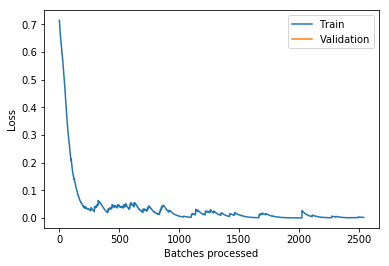

In [17]:
learn.recorder.plot_losses()

In [18]:
learn.save('mdl')

In [19]:
!nvidia-smi

Thu Aug  8 19:51:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   68C    P0    63W / 300W |  15417MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# prediction

In [20]:
preds, y = learn.get_preds(ds_type=DatasetType.Fix)

In [21]:
preds = preds.numpy().squeeze()
y = y.numpy()

In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y, preds[:,1])

0.9999996129446387

In [23]:
df.shape, y.shape, (df.target==y).mean()

((40716, 2), (40716,), 1.0)

In [24]:
np.save(f'{p_o}/preds.npy', preds)
np.save(f'{p_o}/y.npy', y)

In [25]:
imgs = learn.data.train_ds.x.items
np.save(f'{p_o}/imgs.npy', imgs)

# use result

In [26]:
preds.shape

(40716, 2)

In [27]:
scrs = preds[:,1]

In [28]:
idx_sorted = np.argsort(-scrs)
idx_sorted

array([  110,  4803,  2208,  5576, ..., 19304, 30687, 15273, 33949])

In [29]:
idx_old = set(np.where(y==0)[0])
idx_new = set(np.where(y==1)[0])

In [30]:
idx_sorted_old = np.array([o for o in idx_sorted if o in idx_old])
idx_sorted_new = np.array([o for o in idx_sorted if o in idx_new])
len(idx_sorted_old), idx_sorted_old

(35126, array([38848, 18053, 19246, 32091, ..., 19304, 30687, 15273, 33949]))

In [31]:
scrs[idx_sorted_new[:5]]

array([0.999988, 0.999987, 0.999987, 0.999987, 0.999987], dtype=float32)

In [32]:
scrs[idx_sorted_old[:5]]

array([0.997868, 0.922692, 0.603552, 0.527971, 0.107531], dtype=float32)

In [33]:
scrs[idx_sorted_new[-5:]]

array([0.379953, 0.144994, 0.076822, 0.030589, 0.00347 ], dtype=float32)

In [34]:
scrs[idx_sorted_old[-5:]]

array([9.456509e-09, 8.814436e-09, 8.025635e-09, 7.480715e-09, 4.163645e-09], dtype=float32)

In [50]:
imgs[idx_sorted_old[:5]]

array(['./../input/diabetic-retinopathy-resized/resized_train/42007_left.jpeg',
       './../input/diabetic-retinopathy-resized/resized_train/15630_right.jpeg',
       './../input/diabetic-retinopathy-resized/resized_train/17139_left.jpeg',
       './../input/diabetic-retinopathy-resized/resized_train/33555_right.jpeg',
       './../input/diabetic-retinopathy-resized/resized_train/11807_right.jpeg'], dtype='<U71')

In [36]:
idx_diab_sorted = np.array([o.split('/')[-1].split('.')[0] for o in imgs[idx_sorted_old]])
len(idx_diab_sorted)

35126

In [37]:
np.save(f'{p_o}/idx_diab_sorted.npy', idx_diab_sorted)

In [38]:
from PIL import Image as PImage
nsmpl=50
def show_imgs(idx):
    fig, axes = plt.subplots(5, nsmpl//5, figsize=(15,15))
    axes = axes.flatten()
    for i,ind in enumerate(idx):
        ax = axes[i]
        im = PImage.open(imgs[ind])
        im.thumbnail((128,128), PImage.ANTIALIAS)
        ax.set_title(scrs[ind])
        ax.imshow(im)
        ax.axis('off')

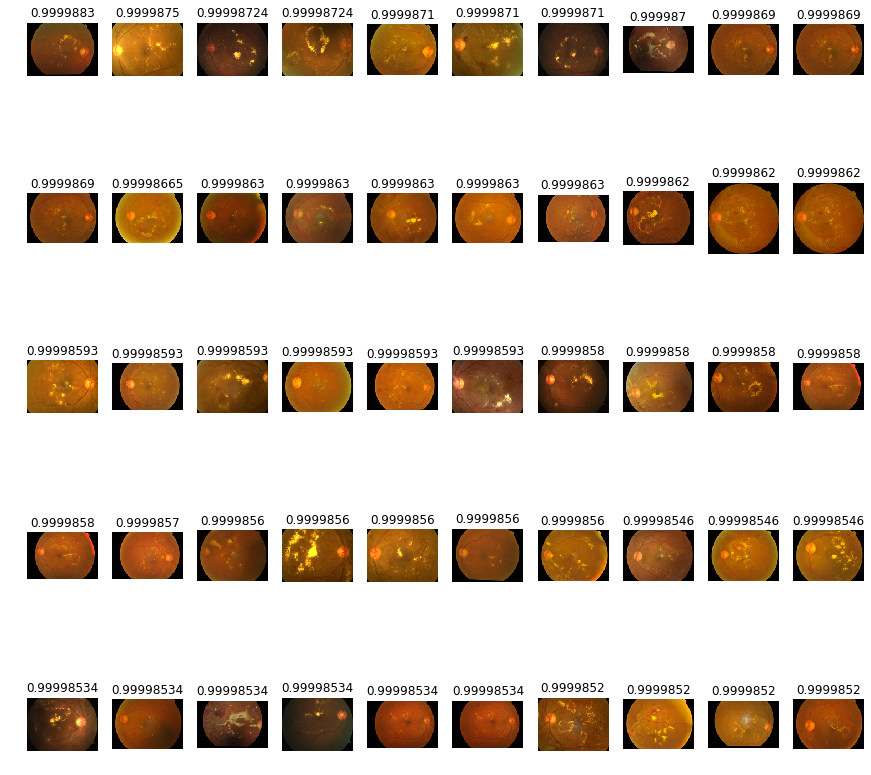

In [39]:
idx = idx_sorted_new[:nsmpl]
show_imgs(idx)

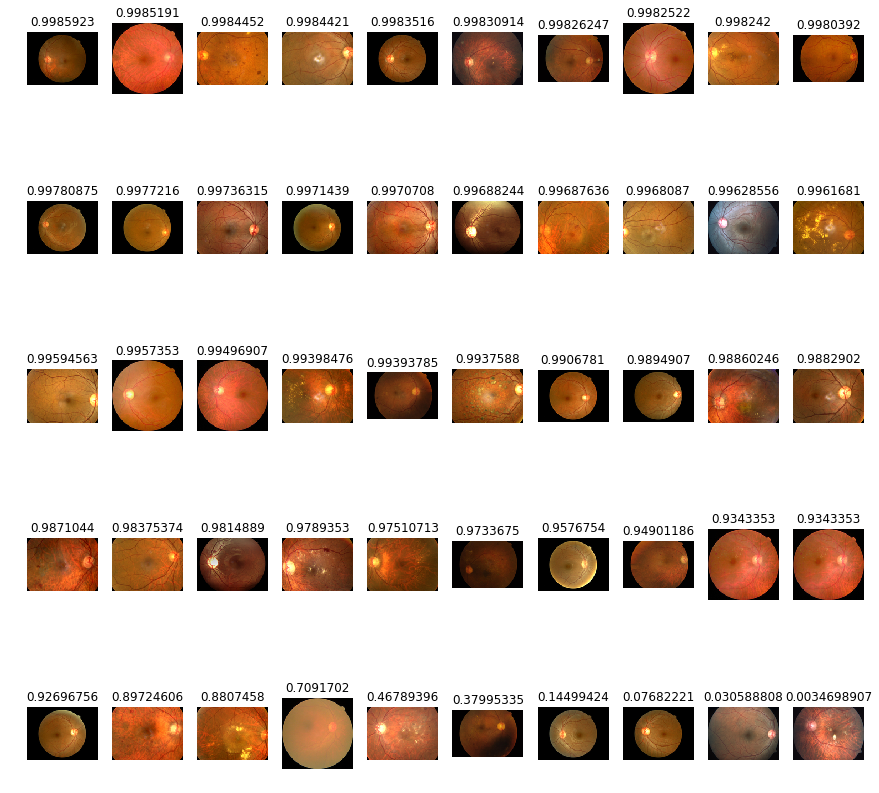

In [40]:
idx = idx_sorted_new[-nsmpl:]
show_imgs(idx)

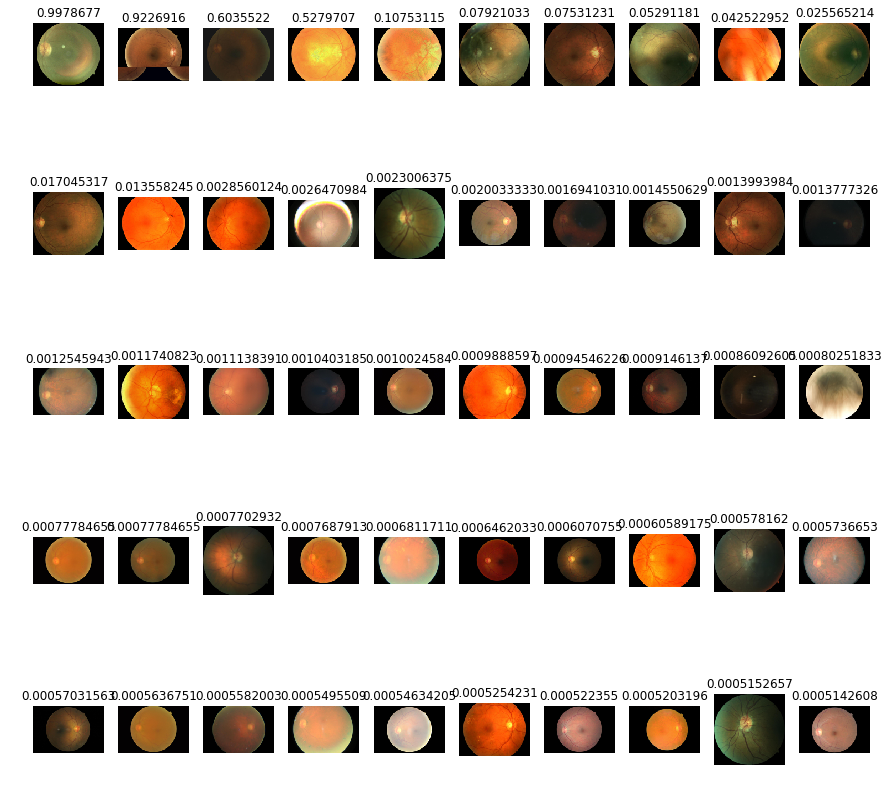

In [41]:
idx = idx_sorted_old[:nsmpl]
show_imgs(idx)

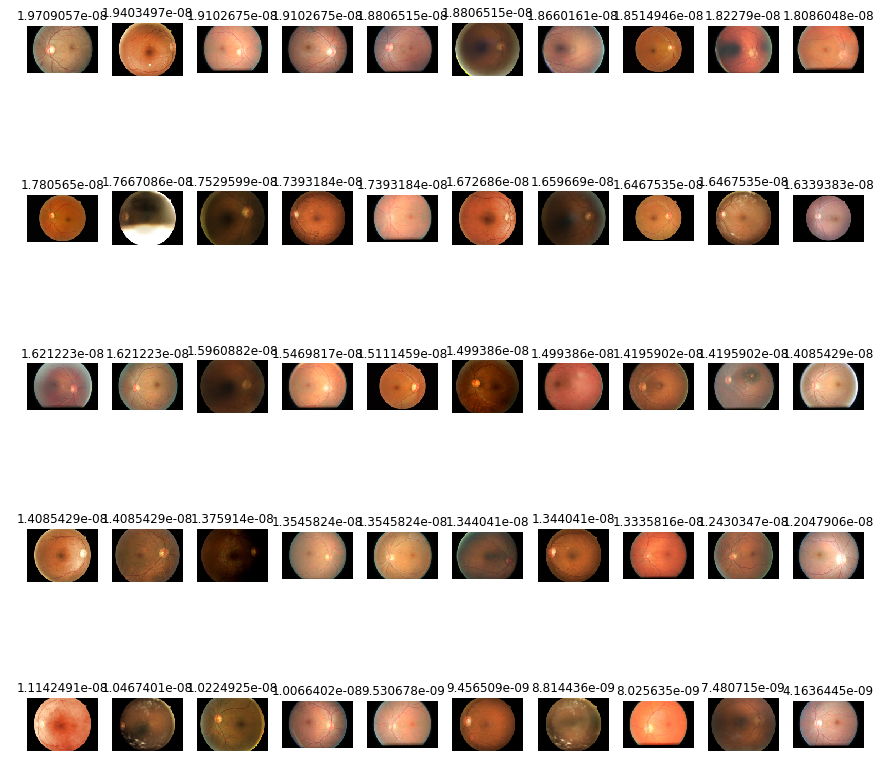

In [42]:
idx = idx_sorted_old[-nsmpl:]
show_imgs(idx)

In [43]:
len(idx_sorted_old)

35126

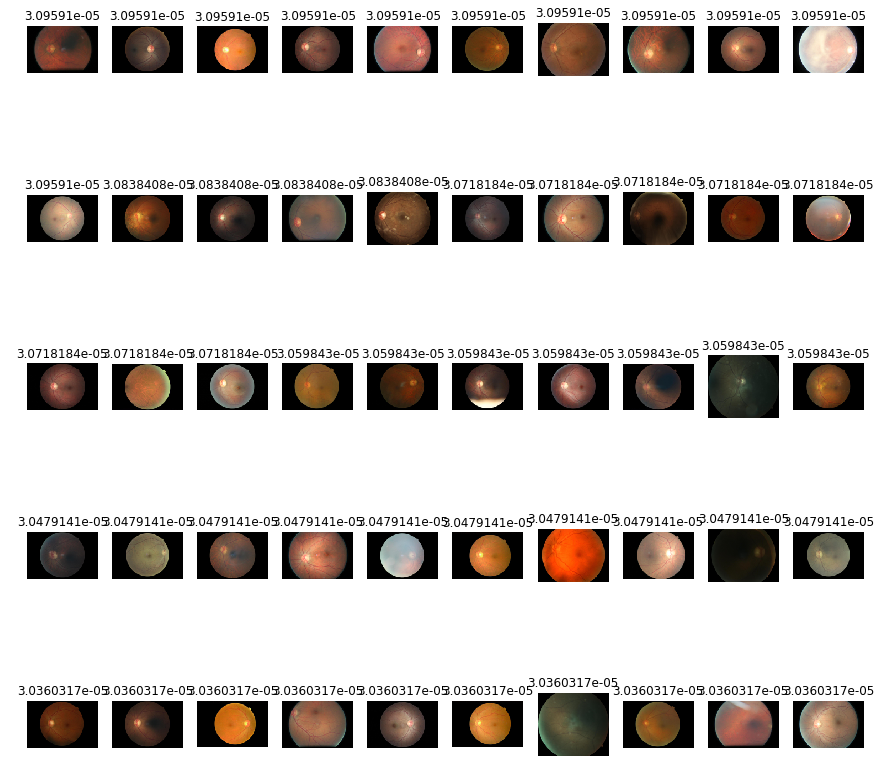

In [44]:
ind_start = 2000
idx = idx_sorted_old[ind_start:ind_start+nsmpl]
show_imgs(idx)

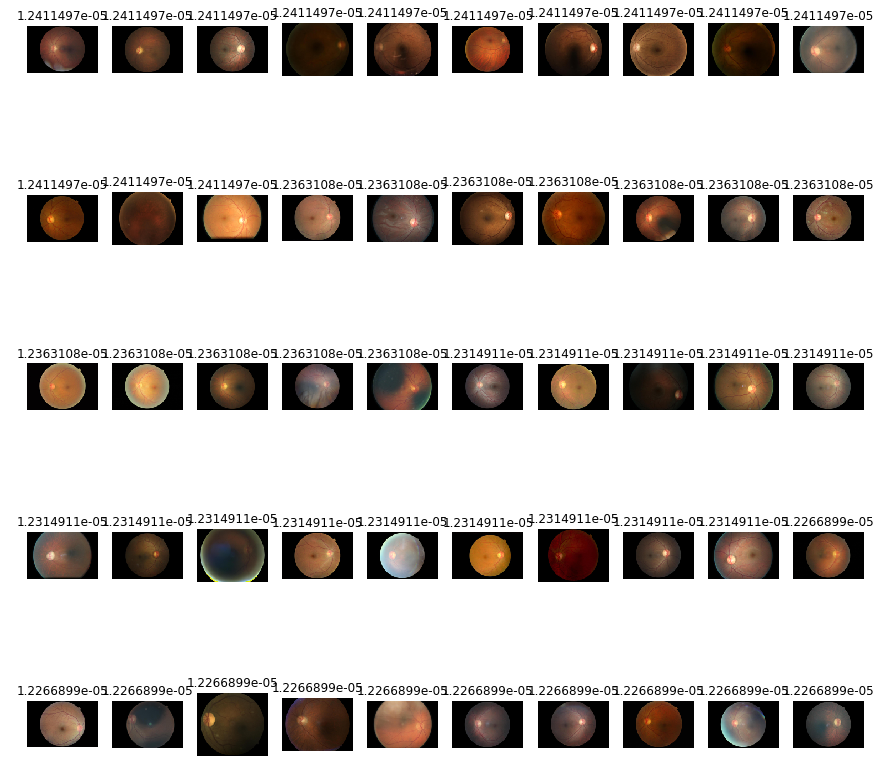

In [45]:
ind_start = 5000
idx = idx_sorted_old[ind_start:ind_start+nsmpl]
show_imgs(idx)

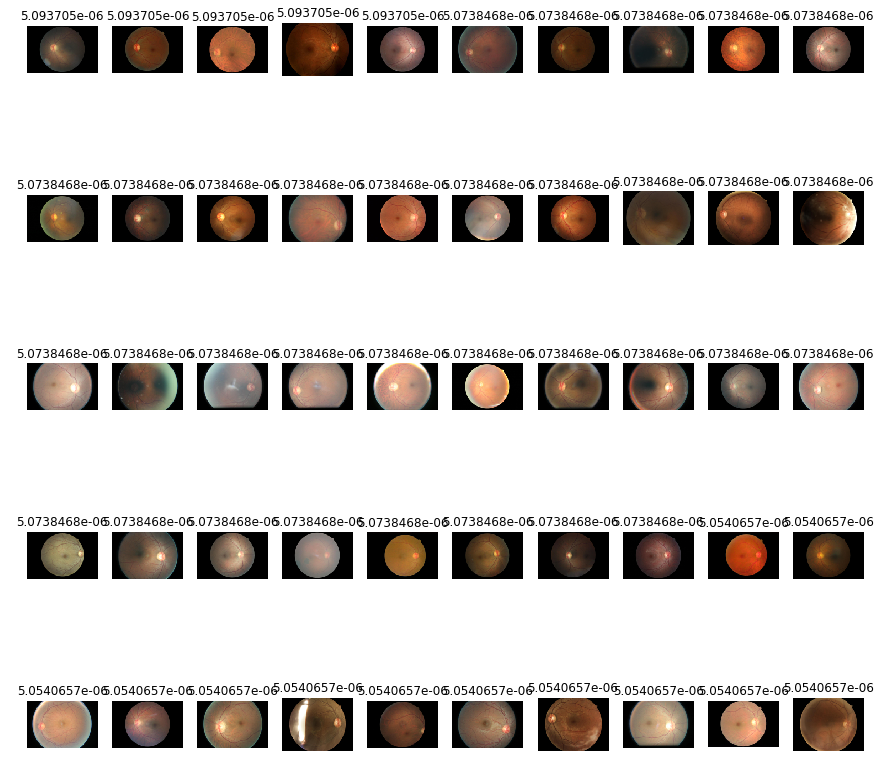

In [46]:
ind_start = 10000
idx = idx_sorted_old[ind_start:ind_start+nsmpl]
show_imgs(idx)

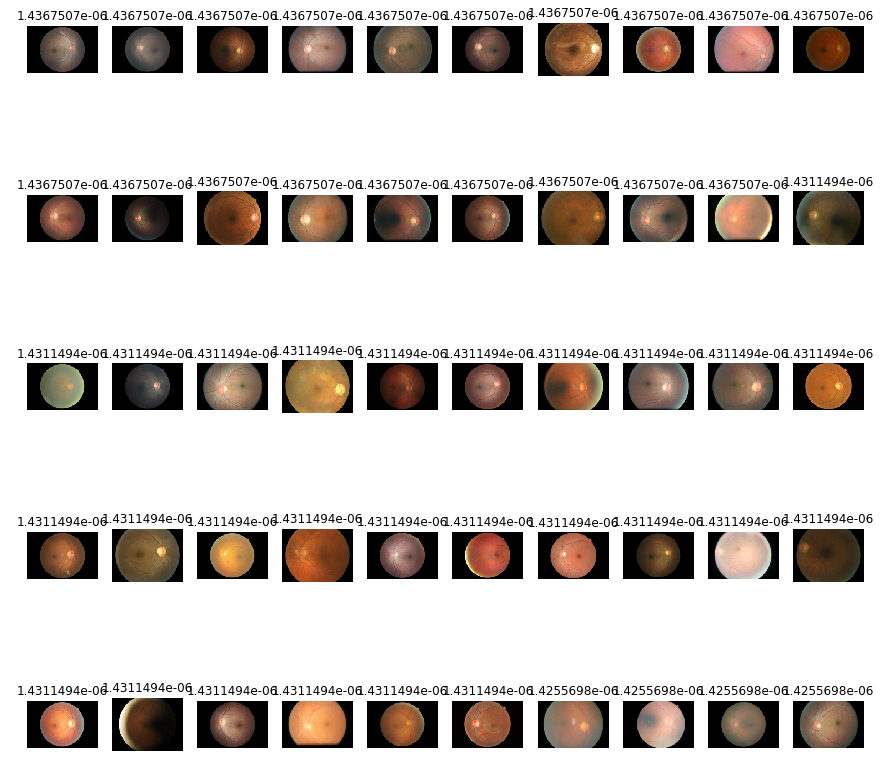

In [47]:
ind_start = 20000
idx = idx_sorted_old[ind_start:ind_start+nsmpl]
show_imgs(idx)

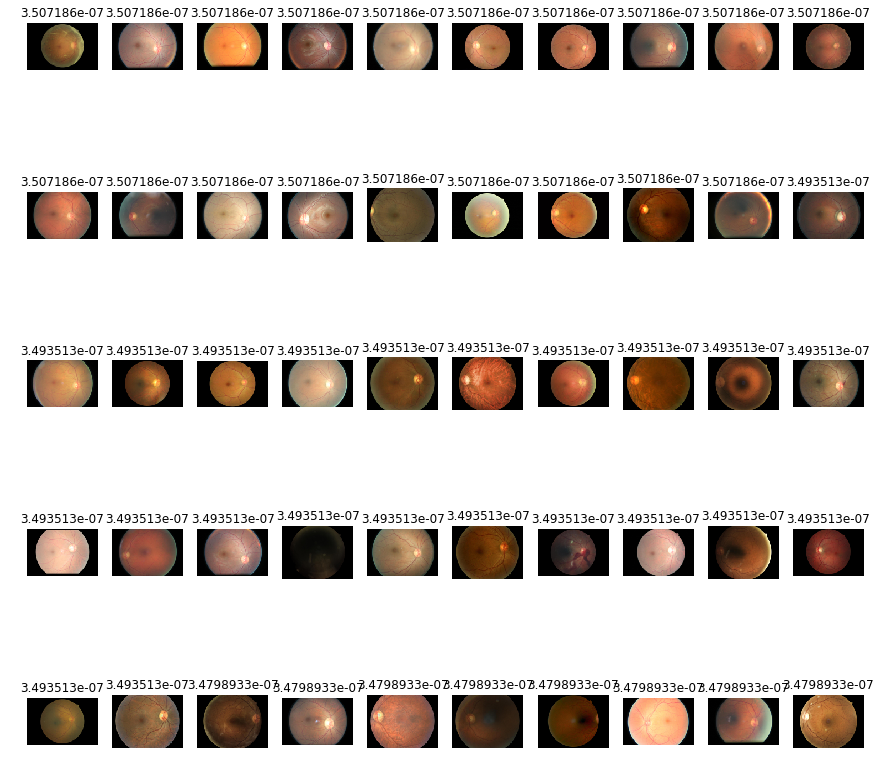

In [48]:
ind_start = 30000
idx = idx_sorted_old[ind_start:ind_start+nsmpl]
show_imgs(idx)

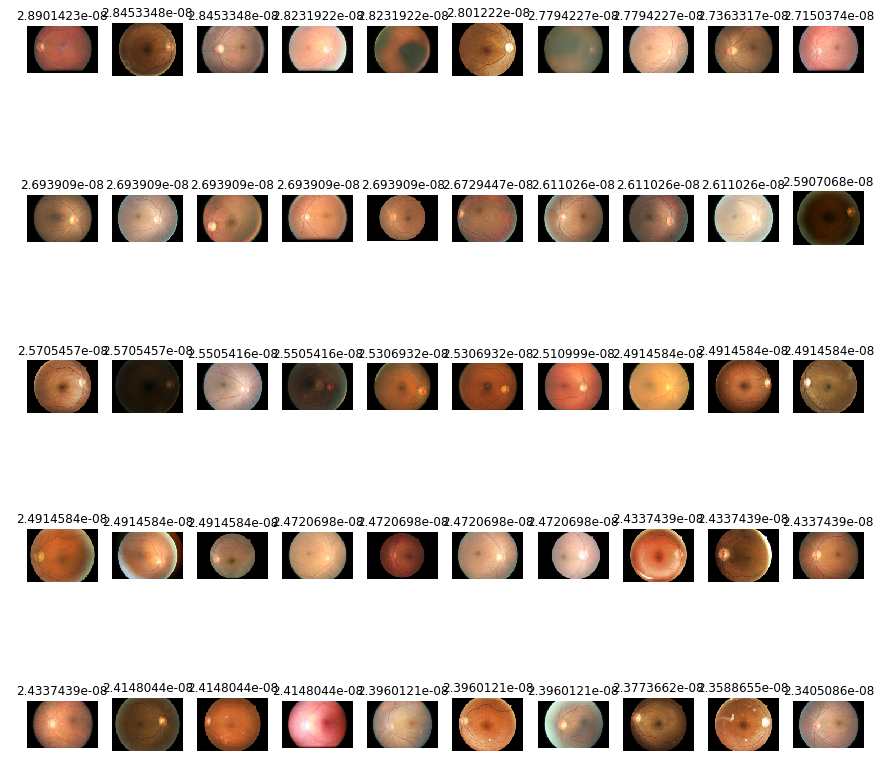

In [49]:
ind_start = 35000
idx = idx_sorted_old[ind_start:ind_start+nsmpl]
show_imgs(idx)